In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import f1_score, confusion_matrix, classification_report


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# device configuration
print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.') 
    device = torch.device('cpu')

Using PyTorch version: 2.4.0+cu124
Using GPU, device name: NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
# define a function to set all seeds to 0
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)

set_seed(0)

In [20]:
from load_datasets import load_mnist_data

train_dataset, test_dataset = load_mnist_data()

# Flatten the images for sklearn MLP
X_train = train_dataset.data.numpy()
y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()

# Summarize loaded dataset
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))


Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


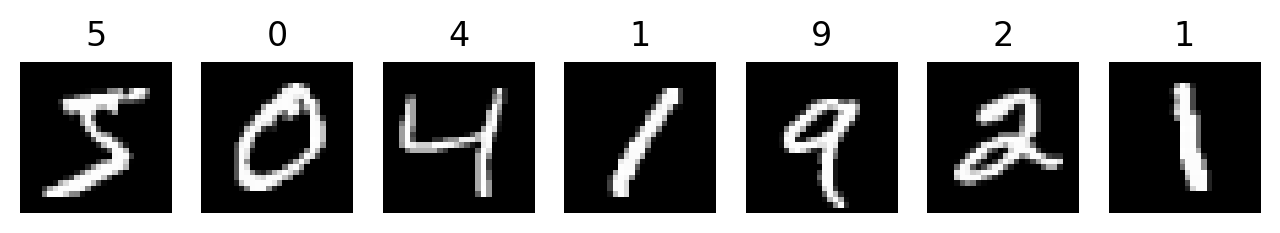

In [6]:
# Plot first few images
fig, axs = plt.subplots(1, 7, figsize=(8, 10))
for i in range(7):
    axs[i].imshow(X_train[i], cmap='gray')
    axs[i].set_title(y_train[i])
    axs[i].axis('off')


In [7]:
# Hyper-parameters
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 60
batch_size = 128
learning_rate = 0.0005


# # next best
# input_size = 784
# hidden_size = 500
# num_classes = 10
# num_epochs = 100
# batch_size = 256
# learning_rate = 0.0008


In [8]:
# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [9]:
# # Create and train the MLP model using PyTorch
# class MLP(nn.Module):
#     def __init__(self, input_size, num_classes, device=device):
#         super(MLP, self).__init__()
#         self.fc1 = nn.Linear(input_size, 30, device = device)      # First hidden layer (30 neurons)
#         self.fc2 = nn.Linear(30, 20, device = device)              # Second hidden layer (20 neurons)
#         self.fc3 = nn.Linear(20, num_classes, device = device)     # Output layer (10 neurons)
    
#     def forward(self, x, input_size, device = device):
#         x = x.view(-1, input_size)  # Flatten the image
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = self.fc3(x)  # No activation here; we'll apply softmax in the loss function
#         return x

In [10]:
class MLP(nn.Module):
    """
    Multi-Layer Perceptron (MLP) for image classification.

    Attributes:
        fc1 (nn.Linear): First fully connected layer.
        relu (nn.ReLU): ReLU activation function.
        fc2 (nn.Linear): Second fully connected layer for output.
    """

    def __init__(self, input_size=28*28, hidden_size=128, num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # First fully connected layer
        self.relu = nn.ReLU()                           # ReLU activation function
        self.fc2 = nn.Linear(hidden_size, num_classes)  # Second fully connected layer

    def forward(self, x):
        # Flatten the image 
        x = x.reshape(-1, 28*28)
        x = self.fc1(x)
        x = self.relu(x)
        out = self.fc2(x)       # No activation here; we'll apply softmax in the loss function
        return out


In [11]:
# Initialize the model
model = MLP(input_size, hidden_size, num_classes).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(model)


MLP(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


In [12]:
def train_and_evaluate_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0
        
        y_train_pred = []  # Reset predictions for each epoch
        y_train_true = []  # True labels for each epoch
        y_train_prob = []  # Predicted probabilities for each epoch

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_train_loss += loss.item()
            
            # Backward and optimize
            loss.backward()
            optimizer.step()
            
            # Store predictions and true labels
            _, predicted = torch.max(outputs.data, 1)
            y_train_pred.extend(predicted.cpu().numpy())
            y_train_true.extend(labels.cpu().numpy())
            y_train_prob.extend(F.softmax(outputs, dim=1).cpu().detach().numpy())
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train
        train_loss = total_train_loss / len(train_loader)
        
        # Evaluate on test data
        model.eval()
        total_test_loss = 0
        correct_test = 0
        total_test = 0
        
        y_test_pred = []  # Reset test predictions for each epoch
        y_test_true = []  # True labels for test set
        y_test_prob = []  # Predicted probabilities for test set

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_test_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                y_test_pred.extend(predicted.cpu().numpy())
                y_test_true.extend(labels.cpu().numpy())
                y_test_prob.extend(F.softmax(outputs, dim=1).cpu().detach().numpy())
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_accuracy = 100 * correct_test / total_test
        test_loss = total_test_loss / len(test_loader)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Train Accuracy: {train_accuracy:.4f}%, Test Loss: {test_loss:.6f}, Test Accuracy: {test_accuracy:.4f}%')

    return model, train_loss, train_accuracy, test_loss, test_accuracy, y_train_true, y_train_pred, y_train_prob, y_test_true, y_test_pred, y_test_prob

# Train and evaluate the model
model, train_loss, train_accuracy, test_loss, test_accuracy, y_train, y_train_pred, y_train_prob, y_test, y_test_pred, y_test_prob = train_and_evaluate_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)


Epoch [10/60], Train Loss: 0.028951, Train Accuracy: 99.2550%, Test Loss: 0.063283, Test Accuracy: 97.9700%
Epoch [20/60], Train Loss: 0.004273, Train Accuracy: 99.9517%, Test Loss: 0.070219, Test Accuracy: 97.9800%
Epoch [30/60], Train Loss: 0.004715, Train Accuracy: 99.8650%, Test Loss: 0.076466, Test Accuracy: 98.0600%
Epoch [40/60], Train Loss: 0.006903, Train Accuracy: 99.7850%, Test Loss: 0.082665, Test Accuracy: 98.1800%
Epoch [50/60], Train Loss: 0.000081, Train Accuracy: 100.0000%, Test Loss: 0.086512, Test Accuracy: 98.2900%
Epoch [60/60], Train Loss: 0.000061, Train Accuracy: 100.0000%, Test Loss: 0.092287, Test Accuracy: 98.2700%


In [25]:
def predict_model(model, test_loader):
    model.eval()
    y_test_pred = []
    y_test_true = []
    y_test_prob = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_test_pred.extend(predicted.cpu().numpy())
            y_test_true.extend(labels.cpu().numpy())
            y_test_prob.extend(F.softmax(outputs, dim=1).cpu().detach().numpy())

    return y_test_true, y_test_pred, y_test_prob

y_train, y_train_pred, y_train_prob = predict_model(model, train_loader)
y_test, y_test_pred, y_test_prob = predict_model(model, test_loader)

Train F1 Score: 1.0000
Test F1 Score: 0.9826

Train Accuracy: 100.0000%
Test Accuracy: 98.2700%



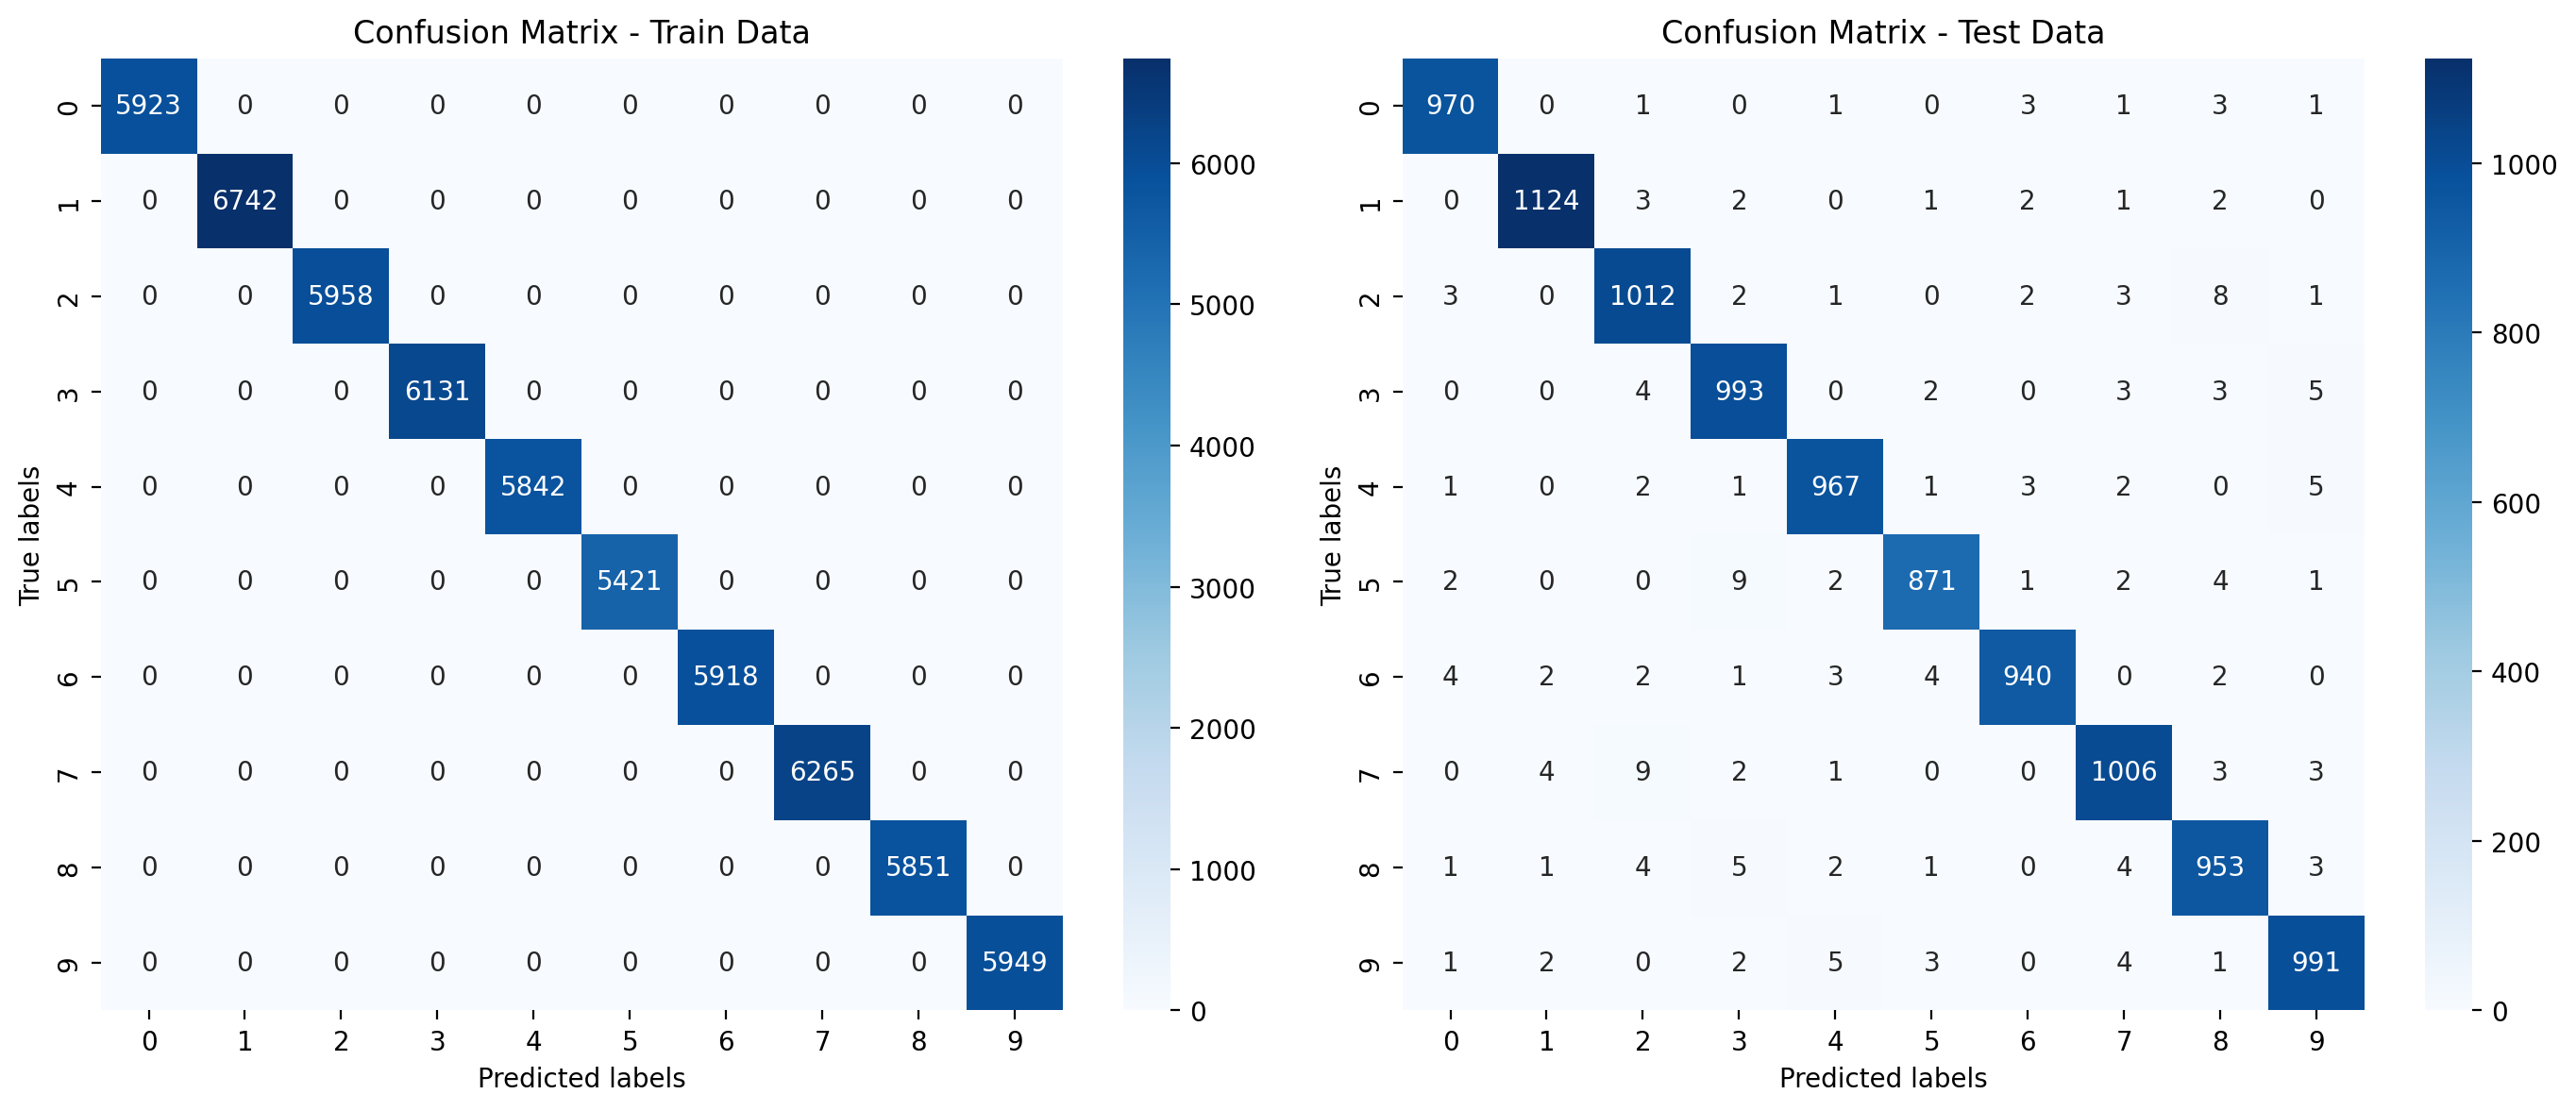

In [26]:
# Calculate F1 scores and confusion matrix
f1_train = f1_score(y_train, y_train_pred, average='macro')
f1_test = f1_score(y_test, y_test_pred, average='macro')
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

print(f'Train F1 Score: {f1_train:.4f}')
print(f'Test F1 Score: {f1_test:.4f}')
print(f'\nTrain Accuracy: {train_accuracy:.4f}%')
print(f'Test Accuracy: {test_accuracy:.4f}%\n')

# Plot confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title('Confusion Matrix - Train Data')
axs[0].set_xlabel('Predicted labels')
axs[0].set_ylabel('True labels')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axs[1])
axs[1].set_title('Confusion Matrix - Test Data')
axs[1].set_xlabel('Predicted labels')
axs[1].set_ylabel('True labels')

plt.tight_layout()
plt.show()


In [27]:
# plot classification report
# print('Train Data Classification Report:')
# print(classification_report(y_train, y_train_pred))
print('Test Data Classification Report:')
print(classification_report(y_test, y_test_pred))

Test Data Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.97      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



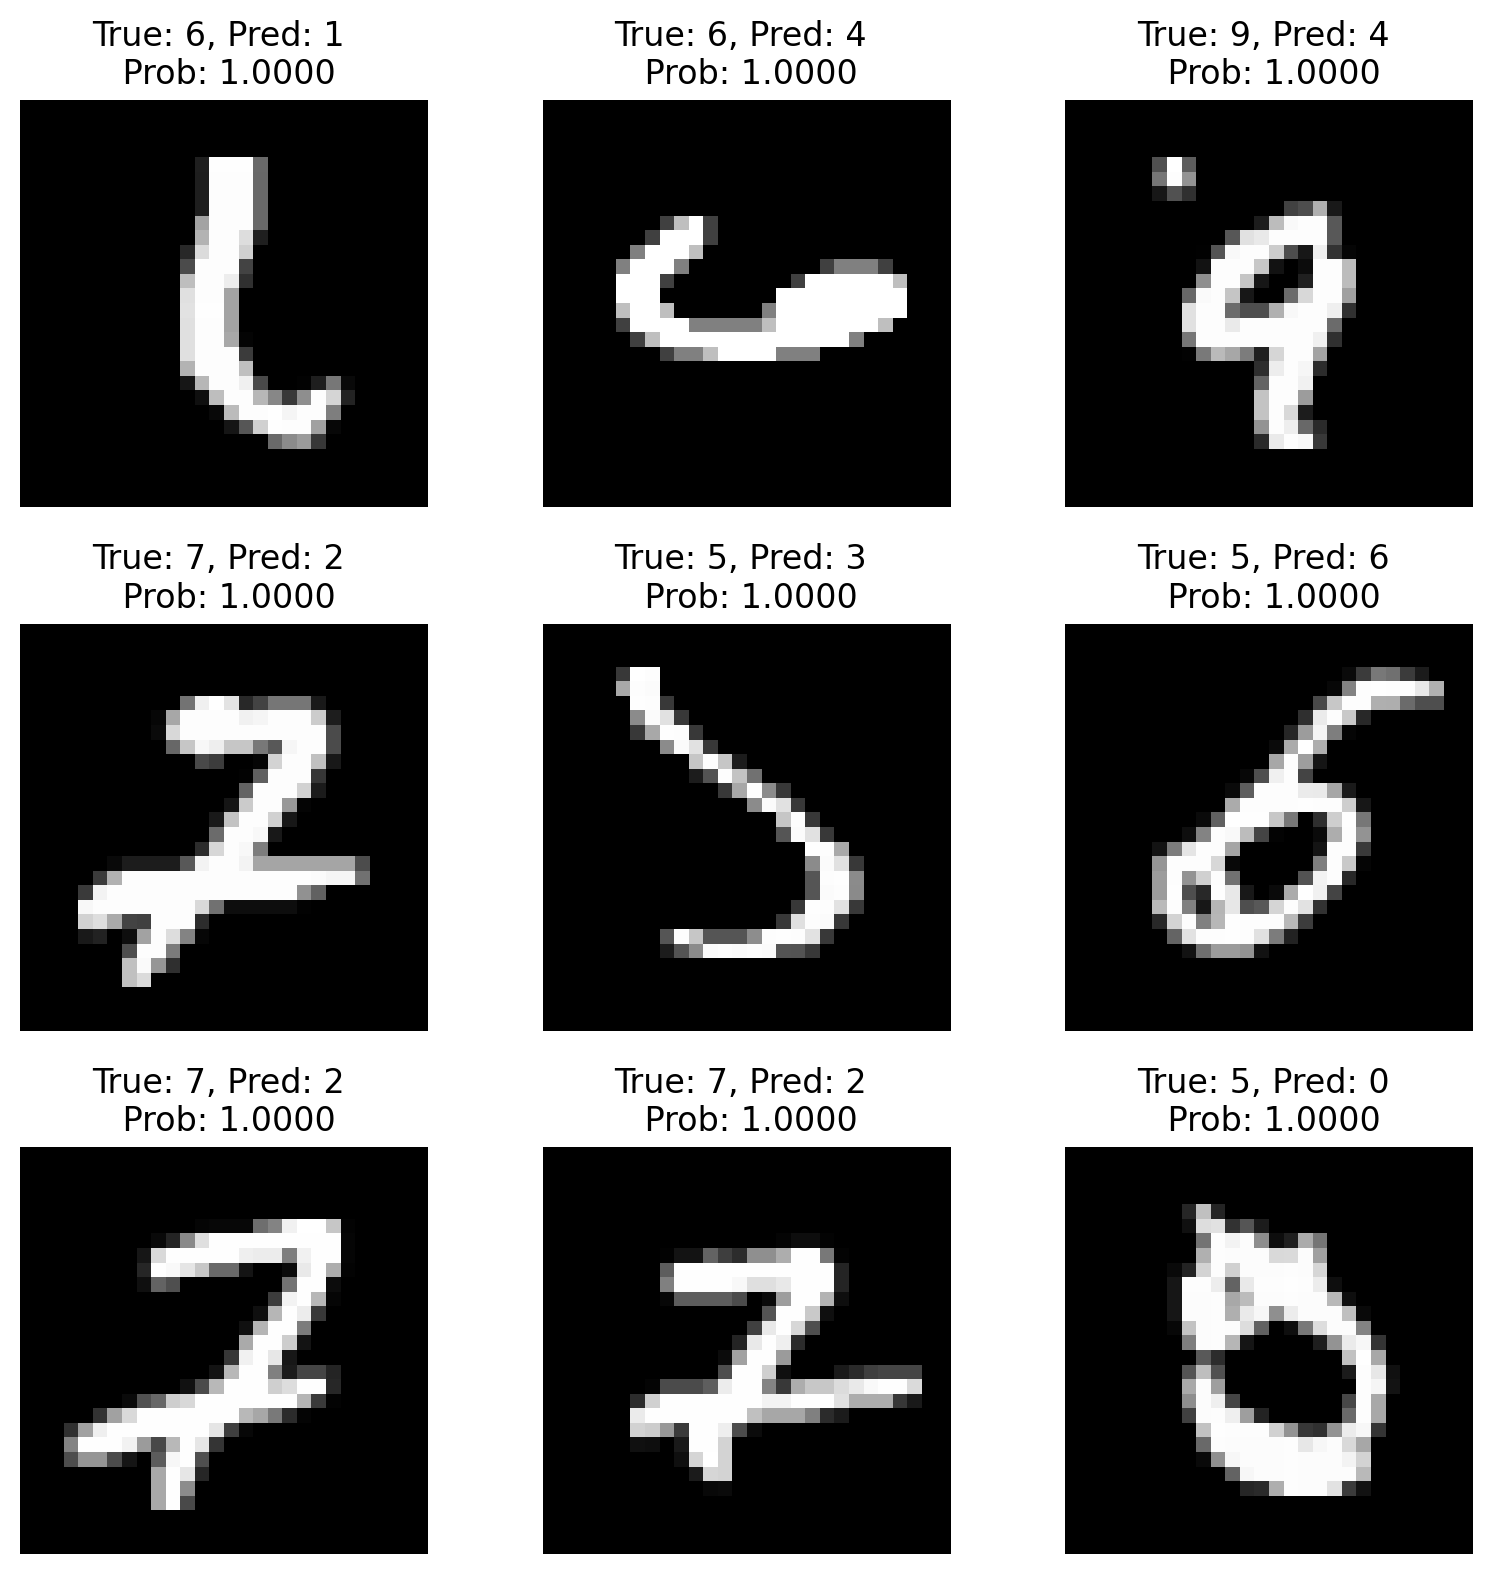

In [28]:
# Display the first k wrongly classified images with highest probability
k = 9
wrong_indices = np.where(np.array(y_test) != np.array(y_test_pred))[0]
wrong_prob = np.array(y_test_prob)[wrong_indices]
wrong_prob_max = np.max(wrong_prob, axis=1)
wrong_prob_indices = np.argsort(wrong_prob_max)[::-1][:k]

fig, axs = plt.subplots(3, 3, figsize=(8, 8))
for i, idx in enumerate(wrong_prob_indices):
    ax = axs[i // 3, i % 3]
    ax.imshow(X_test[wrong_indices[idx]], cmap='gray')
    ax.set_title(f'True: {y_test[wrong_indices[idx]]}, Pred: {y_test_pred[wrong_indices[idx]]} \n Prob: {wrong_prob_max[idx]:.4f}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Save the model checkpoint
torch.save(model.state_dict(), './models/mlp_model_98_27.ckpt')

# Load the model checkpoint
model = MLP(input_size, hidden_size, num_classes).to(device)
model.load_state_dict(torch.load('./models/mlp_model_98_27.ckpt'))

C:\Users\Shardul Junagade\AppData\Local\Temp\ipykernel_2464\2837035765.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/mlp_mod

<All keys matched successfully>